In [7]:
import datetime
import logging
import os.path
import glob
import os.path
import pathlib
import concurrent.futures


import numpy as np
import scipy.stats
import pandas # for tables
import pydash # for functional stuff
import dateutil.parser # garbage date/times
import requests # urls
import matplotlib.pyplot as plt # plotting 
import matplotlib.dates # date axes
import mako.template # html formatting
import IPython.display # notebook
import skimage.io
import skimage.transform
import ssl
import io
from PIL import Image
import mako.template
import IPython.display


%matplotlib inline

# replace default logging
#del logging.root.handlers[0]
#logging.basicConfig(level=logging.INFO)

In [8]:
# Create a sparql query to get all the oil paintings from the wikipedia
query = """

SELECT ?item ?itemLabel ?cid ?_image ?_inception ?_creator ?_creatorLabel WHERE {
  # select all paintings
  ?item wdt:P31 wd:Q3305213.
  # made with oil
  ?item wdt:P186 wd:Q296955.
  # written in english
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  # store the image
  OPTIONAL { ?item wdt:P18 ?_image. }
  # store the creation date
  OPTIONAL { ?item wdt:P571 ?_inception. }
  # store the creator
  OPTIONAL { ?item wdt:P170 ?_creator. }
}
"""

In [9]:
url = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
resp = requests.get(url, 
                    params=dict(query=query), 
                    headers={'Accept': 'application/json'})
data = resp.json()

In [10]:
# take a random sample
sample = False
if sample:
    data['results']['bindings'] = np.random.choice(data['results']['bindings'], replace=False, size=sample)
    len(data['results']['bindings'])

In [11]:
# parse the dates
for row in data['results']['bindings']:
    if '_inception' in row and row['_inception']['type'] == 'literal':
        try:
            date = row['_inception']['value']
            row['date'] = dateutil.parser.parse(date)
        except ValueError as e:
            logging.info("not parsed %s\n%s", date, row)
    if pydash.has(row, 'item.value'):
        entity = row['item']['value'].split("/")[-1]
        row['entity'] = entity
            

In [12]:
# analyze all data
dates = []
for row in data['results']['bindings']:
    if 'date' in row:
        dates.append(
            matplotlib.dates.date2num(row['date'])
        )

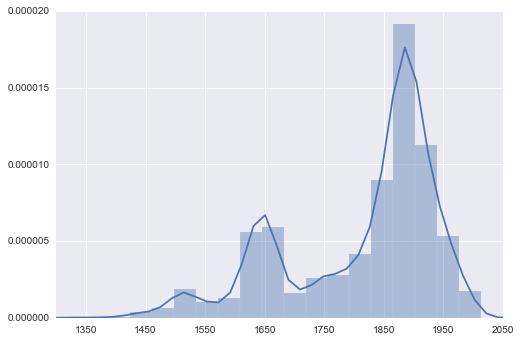

In [15]:
import seaborn
ax = seaborn.distplot(dates)
start_date = matplotlib.dates.date2num(datetime.datetime(1300, 1, 1))
end_date = matplotlib.dates.date2num(datetime.datetime(2050, 1, 1))
ax.set_xlim(start_date, end_date)
ax.xaxis_date()

In [16]:
rows = []
for row in data['results']['bindings']:
    creator = pydash.get(row, '_creatorLabel.value')
    name = pydash.get(row, 'itemLabel.value')

    datestr = pydash.get(row, '_inception.value')
    datetype = pydash.get(row, '_inception.type')
    img = pydash.get(row, '_image.value')
    entity = pydash.get(row, 'entity')
    if datestr and datetype == 'literal':
        try:
            date = dateutil.parser.parse(datestr)
        except:
            logging.exception("error %s\n%s", datestr, row)
    else:
        date = None
    rows.append(
        dict(
            creator=creator,
            name=name,
            date=date,
            img=img,
            entity=entity
        )
    )

In [17]:
df = pandas.DataFrame(data=rows)
df.ix[df.creator == 'anonymous'] = None
# drop missings and duplicates
df = df.dropna().drop_duplicates()
len(df)

18035

In [18]:
table = pandas.crosstab(df.creator, columns=['creator'])
table.sort_values(by="creator", ascending=False).head()

col_0,creator
creator,
Rembrandt,615
Camille Pissarro,406
Dalasito,331
Albert Bierstadt,309
Jacob van Ruisdael,301


In [19]:
df.set_index('entity').head()
df.to_json('paintings.json')

In [20]:
def save_img(row):
    # get url
    url = row['img']
    # lookup id
    entity = row['entity'] 
    filename = "paintings/%s.jpg" % (entity, )
    if os.path.exists(filename):
        print('.', end='', flush=True)
        return
    # download
    print(url)
    try:
        resp = requests.get(url, timeout=5)
    except requests.exceptions.Timeout as e:
        print('t', end='', flush=True)
        return
    print(resp, entity)
    if not resp.status_code == 200:
        print('x', end='', flush=True)
        return
    # get the bytes
    content = io.BytesIO(resp.content)
    
    # open as image
    try:
        im = Image.open(content)
    except:
        print('e', end='', flush=True)
        return
    # scale down
    N = 256
    im.thumbnail((N, N))
    # save
    im.save(filename)
    print('V', end='', flush=True)
row = df.iloc[0].to_dict()
save_img(row)

.

In [ ]:

# work
rows = [row.to_dict() for (i, row) in df.iterrows()]
# execute it

for row in rows:
    try:
        save_img(row)
    except:
        logging.exception("saving failed")
#with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
#    executor.map(save_img, rows)

In [21]:
imgs = df.img
imgs.to_csv('highres/urls.txt', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'highres/urls.txt'

In [22]:
import requests

In [23]:
resp = requests.head(imgs.ix[0], allow_redirects=True)
resp.headers

{'Content-Length': '11855275', 'X-Trans-Id': 'tx6f2a3cc108224bd39c903-005762e90d', 'Via': '1.1 varnish, 1.1 varnish, 1.1 varnish', 'X-Object-Meta-Sha1base36': '3abqs3k27qregir208rex1r8bkp9lv6', 'X-Client-IP': '2001:984:3f61:1:5033:ebea:5f8a:6673', 'X-Timestamp': '1380877054.40181', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Etag': '56c06706ac03a334b31c2f0ec0d4d9ea', 'Connection': 'keep-alive', 'Age': '6135', 'Access-Control-Expose-Headers': 'Age, Date, Content-Length, Content-Range, X-Content-Duration, X-Cache, X-Varnish', 'Last-Modified': 'Fri, 04 Oct 2013 08:57:35 GMT', 'Accept-Ranges': 'bytes', 'X-Varnish': '311053777 289299053, 563854963, 584338549', 'Access-Control-Allow-Origin': '*', 'Timing-Allow-Origin': '*', 'Content-Type': 'image/jpeg', 'X-Analytics': 'https=1', 'Date': 'Thu, 16 Jun 2016 19:41:55 GMT', 'X-Cache': 'cp1049 hit/1, cp3037 miss, cp3037 miss'}

In [66]:
import urllib.parse

# get a token from: /w/api.php?action=query&format=json&meta=tokens&type=csrf%7Clogin

def url2name(url):
    return urllib.parse.unquote(url.split(':')[-1].replace('FilePath/', 'File:'))
names = "|".join(imgs[:50].apply(url2name))
url = 'https://commons.wikimedia.org/w/api.php'
params = {
    "action": "query",
    "titles": names,
    "prop": "imageinfo",
    "iiprop": "timestamp|thumbmime|bitdepth|dimensions|sha1|url|mediatype|metadata|extmetadata",
    "format": "json"
    
}
headers = {'Accept': 'application/json'}
data = requests.get(url, params=params, headers=headers, allow_redirects=True).json() #.content.decode('utf-8')